In [1]:
import geopandas as gpd
import pandas as pd
import h3pandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.font_manager

In [2]:
zeis1 = gpd.read_file("/Users/camillaperotto/Downloads/PDE_4-Zeis1/sirgas_PDE_4-Zeis1.shp")
zeis1.crs = 31983
zeis1 = zeis1.to_crs(4326)

zeisOthers = gpd.read_file("/Users/camillaperotto/Downloads/PDE_4A-Zeis2-3-4-5/sad6996_PDE_4A-Zeis2,3,4,5.shp")
zeisOthers.crs = 31983
zeisOthers = zeisOthers.to_crs(4326)

zeis = zeisOthers.append(zeis1)
len(zeis), len(zeis1), len(zeisOthers)

DriverError: /Users/camillaperotto/Downloads/PDE_4-Zeis1/sirgas_PDE_4-Zeis1.shp: No such file or directory

In [3]:
eetu = gpd.read_file("/Users/camillaperotto/Downloads/PDE_3-Eixos-EETU/sirgas_PDE_3-Eixos-EETU.shp")
eetu.crs = 31983
eetu = eetu.to_crs(4326)
eetu.head(3)

,sg_macro_d,cd_perimet,nm_perimet,qt_area_pe,nm_tema_di,tx_macro_d,cd_macro_d,cd_tema_di,geometry
0,EETU,1291,Area de Influencia,3270.1400,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((-46.57676 -23.58461, -46.57684 -23.5..."
1,EETU,1293,Area de Influencia,10253.8000,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((-46.57601 -23.58225, -46.57597 -23.5..."
2,EETU,1301,Area de Influencia,13803.7800,Eixos de Estruturação da Transformação Urbana,Eixos da Estruturação da Transformação Urbana,53,3,"POLYGON ((-46.68561 -23.62574, -46.68564 -23.6..."


In [3]:
alv = pd.read_excel("/Users/camillaperotto/Downloads/Dadosaula6 2/alvaras_por_lote.xlsx")
alv_points = pd.read_csv("/Users/camillaperotto/Downloads/Dadosaula6 2/alvaras_por_lote_geolocWGS84.csv", sep=';')
alv = alv.merge(alv_points, on='id')
his = alv[(alv.categoria_de_uso_registro.str.contains('HIS')) & (alv.ind_outlier == False)].reset_index(drop=True)
his['geometry'] = his.apply(lambda row: Point(row['X'], row['Y']), axis=1)
his = gpd.GeoDataFrame(his)

his['zeis'] = False
his['eetu'] = False
zeisIntersection = gpd.overlay(his, zeis)['id'].unique()
his.loc[his['id'].isin(zeisIntersection), 'zeis'] = True
eetuIntersection = gpd.overlay(his, eetu)['id'].unique()
his.loc[his['id'].isin(eetuIntersection), 'eetu'] = True

his.head(3)

AttributeError: 'DataFrame' object has no attribute 'categoria_de_uso_registro'

In [5]:
access = pd.read_csv("/Users/camillaperotto/Downloads/aop_access_publictransport_2019_v2.csv")
access = access[
    (access.abbrev_muni == 'spo') & (access['mode'] == 'public_transport') & (access.year == 2019) & (access.peak == 1)
].reset_index(drop=True)
access.head(3)

/var/folders/73/66hhl4fn15q00wfhkpxpsy680000gq/T/ipykernel_1014/764768472.py:1: DtypeWarning: Columns (170) have mixed types. Specify dtype option on import or set low_memory=False.
  access = pd.read_csv("/Users/camillaperotto/Downloads/aop_access_publictransport_2019_v2.csv")


,year,id_hex,abbrev_muni,name_muni,code_muni,mode,peak,CMATT15,CMATB15,CMATM15,...,CMPP70I120,TMIST,TMISB,TMISM,TMISA,TMIET,TMIEI,TMIEF,TMIEM,TMICT
0,2019,89a81000003ffff,spo,Sao Paulo,3550308,public_transport,1,315,71,175,...,258748,17.0,17.0,17.0,53.0,8.0,26.0,8.0,8.0,21.0
1,2019,89a81000007ffff,spo,Sao Paulo,3550308,public_transport,1,313,70,174,...,249978,21.0,21.0,21.0,55.0,9.0,28.0,9.0,9.0,23.0
2,2019,89a8100000bffff,spo,Sao Paulo,3550308,public_transport,1,229,43,161,...,280017,13.0,13.0,13.0,50.0,17.0,26.0,17.0,17.0,30.0


<h3>Global measurements<h3>

In [6]:
access[['CMATT60', 'CMAET60']].describe()

,CMATT60,CMAET60
count,1.357500e+04,13575.000000
mean,4.869012e+05,201.957348
std,6.091824e+05,174.081864
min,0.000000e+00,0.000000
25%,8.858000e+03,30.000000
50%,1.961210e+05,185.000000
75%,7.840860e+05,317.000000
max,2.753557e+06,997.000000


<h3>HIS measurements</h3>

In [7]:
interestingCols = ['id_hex', 'CMATT60', 'CMAET60', 'n_unidades', 'area_da_construcao', 'area_do_terreno', 'eetu', 'zeis']
resolution = 9
his_hex = his.h3.geo_to_h3(resolution) 
his_hex = his_hex.merge(access, left_on='h3_09', right_on='id_hex', how='left')
#his_hex['CMATT60_n_unidades'] = his_hex.n_unidades*his_hex.CMATT60/his_hex.n_unidades.sum()
#his_hex['CMAET60_n_unidades'] = his_hex.n_unidades*his_hex.CMAET60/his_hex.n_unidades.sum()
his_hex[interestingCols].describe() 

,CMATT60,CMAET60,n_unidades,area_da_construcao,area_do_terreno
count,1.834000e+03,1834.000000,1482.000000,1.781000e+03,1807.000000
mean,7.912585e+05,382.546347,114.723347,6.984172e+03,3695.337847
std,5.361437e+05,144.519450,292.380320,3.252069e+04,24647.193303
min,6.789000e+03,5.000000,1.000000,1.015000e+02,89.510000
25%,3.831202e+05,267.250000,12.000000,5.882300e+02,271.550000
50%,6.824140e+05,377.000000,20.000000,1.032310e+03,412.500000
75%,1.068485e+06,483.750000,127.500000,6.418370e+03,2001.000000
max,2.582796e+06,997.000000,6912.000000,1.167124e+06,832351.160000


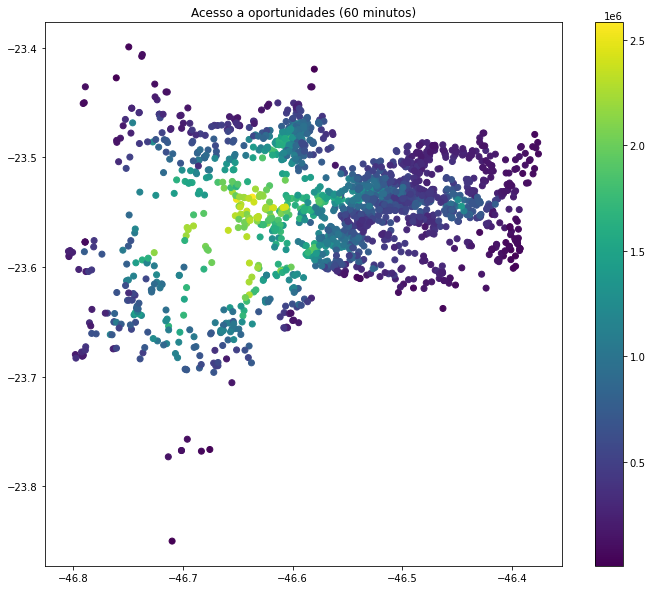

In [8]:
his_hex.plot(figsize=(12, 10), column='CMATT60', cmap='viridis', legend=True)
plt.title('Acesso a oportunidades (60 minutos)');

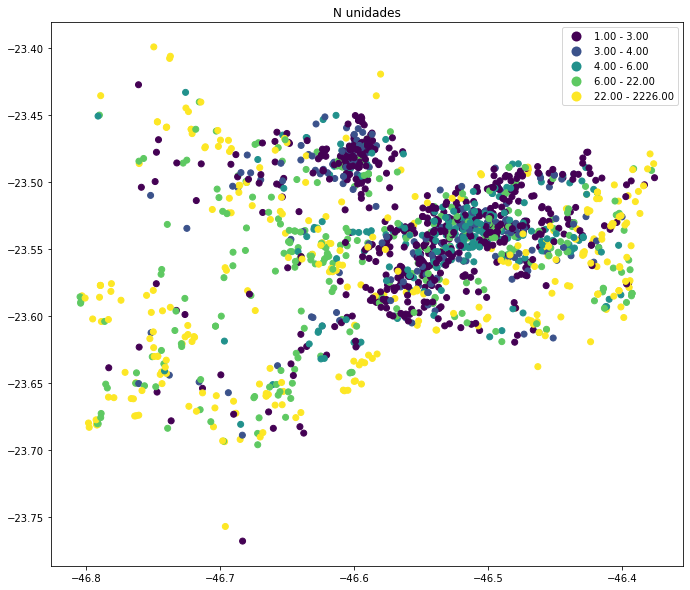

In [9]:
his_hex.plot(figsize=(12, 10), column='n_pavimentos', cmap='viridis', legend=True, scheme='quantiles')
plt.title('N unidades');

,CMATT60,CMATT60 HIS,CMATT60 HIS EETU,CMATT60 HIS ZEIS,CMATT60 HIS NOT ZEIS EETU
count,1.206200e+04,1.271000e+03,1.310000e+02,2.350000e+02,3.610000e+02
mean,5.479758e+05,7.955991e+05,1.186056e+06,6.172535e+05,8.172749e+05
std,6.198276e+05,5.543176e+05,5.657484e+05,6.212923e+05,6.626928e+05
min,1.000000e+00,6.789000e+03,1.540780e+05,3.182800e+04,3.182800e+04
25%,4.121775e+04,3.571220e+05,7.320255e+05,1.657890e+05,2.420240e+05
50%,2.837325e+05,6.799390e+05,1.121114e+06,3.770840e+05,6.819890e+05
75%,8.867998e+05,1.115086e+06,1.629783e+06,8.214225e+05,1.244611e+06
max,2.753557e+06,2.582796e+06,2.502949e+06,2.582796e+06,2.582796e+06


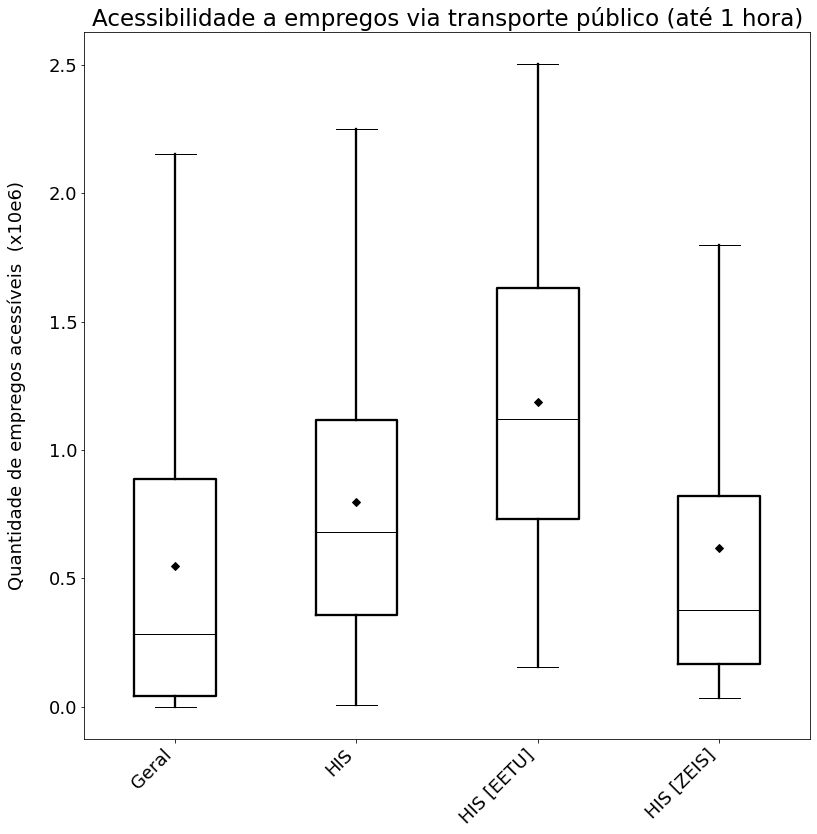

In [65]:
plotDF = access[['CMATT60', 'id_hex']].loc[access.CMATT60 > 0]
plotDF['CMATT60 HIS'] = plotDF.CMATT60
plotDF['CMATT60 HIS EETU'] = plotDF.CMATT60
plotDF['CMATT60 HIS ZEIS'] = plotDF.CMATT60
plotDF.loc[~plotDF.id_hex.isin(his_hex.id_hex.unique()), 'CMATT60 HIS'] = None
plotDF['CMATT60 HIS NOT ZEIS EETU'] = plotDF['CMATT60 HIS']
eetuIDXs = his_hex[his_hex.eetu == True]['id_hex'].unique()
zeisIDXs = his_hex[his_hex.zeis == True]['id_hex'].unique()
plotDF.loc[~plotDF.id_hex.isin(eetuIDXs), 'CMATT60 HIS EETU'] = None
plotDF.loc[~plotDF.id_hex.isin(zeisIDXs), 'CMATT60 HIS ZEIS'] = None
plotDF.loc[(plotDF.id_hex.isin(his_hex.id_hex.unique())) & (~plotDF.id_hex.isin(eetuIDXs)) & (~plotDF.id_hex.isin(zeisIDXs)), 'CMATT60 HIS NOT ZEIS EETU'] = None

boxplotColor = 'black'
renamedCols = {'CMATT60': "Geral", 'CMATT60 HIS': 'HIS', 'CMATT60 HIS EETU': 'HIS [EETU]', 'CMATT60 HIS ZEIS': 'HIS [ZEIS]'}
ax = plotDF[
    ['CMATT60', 'CMATT60 HIS', 'CMATT60 HIS EETU', 'CMATT60 HIS ZEIS']
].rename(columns=renamedCols).plot.box(
    figsize=(13,13), #markerface=dict(means=boxplotColor),
    color=dict(boxes=boxplotColor, whiskers=boxplotColor, medians=boxplotColor, caps=boxplotColor),
    boxprops=dict(linewidth=2.3), showfliers=False, showmeans=True,
    whiskerprops=dict(linestyle='-', linewidth=2.3), 
    meanprops=dict(marker='D', markeredgecolor=boxplotColor, markerfacecolor=boxplotColor)
) 
ax.set_title('Acessibilidade a empregos via transporte público (até 1 hora)', fontsize=23)
ax.tick_params(labelsize=18)
ax.yaxis.offsetText.set_visible(False)
#ax.yaxis.set_label_text()
plt.ylabel("Quantidade de empregos acessíveis" + "  " + '(x10e6)', fontsize=18, labelpad=23)
plt.xticks(rotation=45, ha='right')
ax
plotDF.describe()

In [82]:
plotDF.rename(columns=renamedCols).describe().loc[:]

,Geral,HIS,HIS [EETU],HIS [ZEIS],CMATT60 HIS NOT ZEIS EETU
count,1.206200e+04,1.271000e+03,1.310000e+02,2.350000e+02,3.610000e+02
mean,5.479758e+05,7.955991e+05,1.186056e+06,6.172535e+05,8.172749e+05
std,6.198276e+05,5.543176e+05,5.657484e+05,6.212923e+05,6.626928e+05
min,1.000000e+00,6.789000e+03,1.540780e+05,3.182800e+04,3.182800e+04
25%,4.121775e+04,3.571220e+05,7.320255e+05,1.657890e+05,2.420240e+05
50%,2.837325e+05,6.799390e+05,1.121114e+06,3.770840e+05,6.819890e+05
75%,8.867998e+05,1.115086e+06,1.629783e+06,8.214225e+05,1.244611e+06
max,2.753557e+06,2.582796e+06,2.502949e+06,2.582796e+06,2.582796e+06


In [187]:
plotDF.CMATT60.mean()

547975.7731719449

,CMAET60,CMAET60 HIS,CMAET60 HIS EETU,CMAET60 HIS ZEIS,CMAET60 HIS NOT ZEIS EETU
count,11230.000000,1271.000000,131.000000,235.00000,10320.000000
mean,244.129207,376.117231,460.709924,360.33617,233.108333
std,162.286207,148.617454,140.877387,170.07857,159.458565
min,1.000000,5.000000,179.000000,73.00000,1.000000
25%,122.000000,262.500000,359.000000,231.00000,111.750000
50%,227.000000,368.000000,458.000000,331.00000,215.000000
75%,347.000000,473.500000,536.500000,477.50000,332.000000
max,997.000000,997.000000,872.000000,988.00000,993.000000


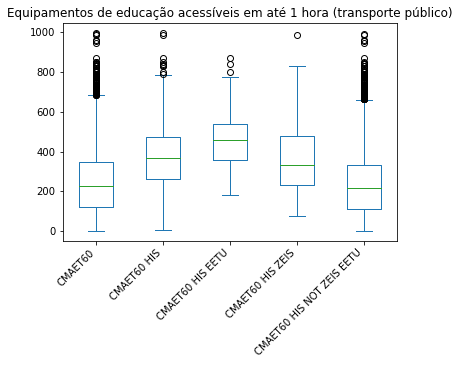

In [175]:
plotDF = access[['CMAET60', 'id_hex']].loc[access.CMAET60 > 0]
plotDF['CMAET60 HIS'] = plotDF.CMAET60
plotDF['CMAET60 HIS EETU'] = plotDF.CMAET60
plotDF['CMAET60 HIS ZEIS'] = plotDF.CMAET60
plotDF['CMAET60 HIS NOT ZEIS EETU'] = plotDF.CMAET60
plotDF.loc[~plotDF.id_hex.isin(his_hex.id_hex.unique()), 'CMAET60 HIS'] = None
eetuIDXs = his_hex[his_hex.eetu == True]['id_hex'].unique()
zeisIDXs = his_hex[his_hex.zeis == True]['id_hex'].unique()
plotDF.loc[~plotDF.id_hex.isin(eetuIDXs), 'CMAET60 HIS EETU'] = None
plotDF.loc[~plotDF.id_hex.isin(zeisIDXs), 'CMAET60 HIS ZEIS'] = None
plotDF.loc[(plotDF.id_hex.isin(his_hex.id_hex.unique())) & (~plotDF.id_hex.isin(eetuIDXs)) & (~plotDF.id_hex.isin(zeisIDXs)), 'CMAET60 HIS NOT ZEIS EETU'] = None
ax = plotDF[
    ['CMAET60', 'CMAET60 HIS', 'CMAET60 HIS EETU', 'CMAET60 HIS ZEIS', 'CMAET60 HIS NOT ZEIS EETU']
].plot.box()
ax.set_title('Equipamentos de educação acessíveis em até 1 hora (transporte público)')
plt.xticks(rotation=45, ha='right')
ax
plotDF.describe()

,CMAST60,CMAST60 HIS,CMAST60 HIS EETU,CMAST60 HIS ZEIS,CMAST60 HIS NOT ZEIS EETU
count,11109.000000,1271.000000,131.000000,235.000000,10199.000000
mean,104.815555,154.152636,203.893130,137.285106,100.626042
std,78.208039,68.596380,67.353631,83.257963,78.187081
min,1.000000,3.000000,70.000000,18.000000,1.000000
25%,40.000000,107.000000,156.000000,80.000000,36.000000
50%,94.000000,144.000000,201.000000,116.000000,86.000000
75%,153.000000,193.000000,253.500000,181.500000,148.000000
max,442.000000,442.000000,381.000000,442.000000,442.000000


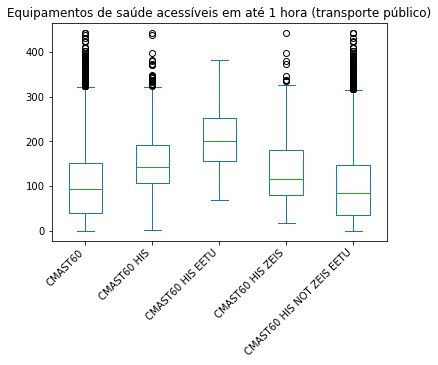

In [174]:
plotDF = access[['CMAST60', 'id_hex']].loc[access.CMAST60 > 0]
plotDF['CMAST60 HIS'] = plotDF.CMAST60
plotDF['CMAST60 HIS EETU'] = plotDF.CMAST60
plotDF['CMAST60 HIS ZEIS'] = plotDF.CMAST60
plotDF['CMAST60 HIS NOT ZEIS EETU'] = plotDF.CMAST60
plotDF.loc[~plotDF.id_hex.isin(his_hex.id_hex.unique()), 'CMAST60 HIS'] = None
eetuIDXs = his_hex[his_hex.eetu == True]['id_hex'].unique()
zeisIDXs = his_hex[his_hex.zeis == True]['id_hex'].unique()
plotDF.loc[~plotDF.id_hex.isin(eetuIDXs), 'CMAST60 HIS EETU'] = None
plotDF.loc[~plotDF.id_hex.isin(zeisIDXs), 'CMAST60 HIS ZEIS'] = None
plotDF.loc[(plotDF.id_hex.isin(his_hex.id_hex.unique())) & (~plotDF.id_hex.isin(eetuIDXs)) & (~plotDF.id_hex.isin(zeisIDXs)), 'CMAST60 HIS NOT ZEIS EETU'] = None
ax = plotDF[
    ['CMAST60', 'CMAST60 HIS', 'CMAST60 HIS EETU', 'CMAST60 HIS ZEIS', 'CMAST60 HIS NOT ZEIS EETU']
].plot.box()
ax.set_title('Equipamentos de saúde acessíveis em até 1 hora (transporte público)')
plt.xticks(rotation=45, ha='right')
ax
plotDF.describe()

In [185]:
his_hex.to_file("HIS_ACESSIBILIDADE.geojson", driver="GeoJSON")

/usr/local/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:174: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
